# Sowing Success: How Machine Learning Helps Farmers Select the Best Crops

<i>Measuring essential soil metrics such as nitrogen, phosphorous, potassium levels, and pH value is an important aspect of assessing soil condition. However, it can be an expensive and time-consuming process, which can cause farmers to prioritize which metrics to measure based on their budget constraints.

Farmers have various options when it comes to deciding which crop to plant each season. Their primary objective is to maximize the yield of their crops, taking into account different factors. One crucial factor that affects crop growth is the condition of the soil in the field, which can be assessed by measuring basic elements such as nitrogen and potassium levels. Each crop has an ideal soil condition that ensures optimal growth and maximum yield.</i>

The dataset can be found in the data folder with the file name `soil_measures.csv`, which contains:

- `"N"`: Nitrogen content ratio in the soil
- `"P"`: Phosphorous content ratio in the soil
- `"K"`: Potassium content ratio in the soil
- `"pH"` value of the soil
- `"crop"`: categorical values that contain various crops (target variable).

Each row in this dataset represents various measures of the soil in a particular field. Based on these measurements, the crop specified in the `"crop"` column is the optimal choice for that field.  

This project contains multi-class classification models to predict the type of `"crop"` and identify the single most importance feature for predictive performance.

### Import libraries

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

### Load and Explore Data

In [56]:
# Load the dataset
crops_df = pd.read_csv("../data/soil_measures.csv")

crops_df.head()

,N,P,K,ph,crop
0,90,42,43,6.502985,rice
1,85,58,41,7.038096,rice
2,60,55,44,7.840207,rice
3,74,35,40,6.980401,rice
4,78,42,42,7.628473,rice


In [57]:
crops_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   N       2200 non-null   int64  
 1   P       2200 non-null   int64  
 2   K       2200 non-null   int64  
 3   ph      2200 non-null   float64
 4   crop    2200 non-null   object 
dtypes: float64(1), int64(3), object(1)
memory usage: 86.1+ KB


In [58]:
crops_df.describe()

,N,P,K,ph
count,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,6.469480
std,36.917334,32.985883,50.647931,0.773938
min,0.000000,5.000000,5.000000,3.504752
25%,21.000000,28.000000,20.000000,5.971693
50%,37.000000,51.000000,32.000000,6.425045
75%,84.250000,68.000000,49.000000,6.923643
max,140.000000,145.000000,205.000000,9.935091


In [59]:
crops_df['crop'].unique()

array(['rice', 'maize', 'chickpea', 'kidneybeans', 'pigeonpeas',
       'mothbeans', 'mungbean', 'blackgram', 'lentil', 'pomegranate',
       'banana', 'mango', 'grapes', 'watermelon', 'muskmelon', 'apple',
       'orange', 'papaya', 'coconut', 'cotton', 'jute', 'coffee'],
      dtype=object)

### Data Visualization

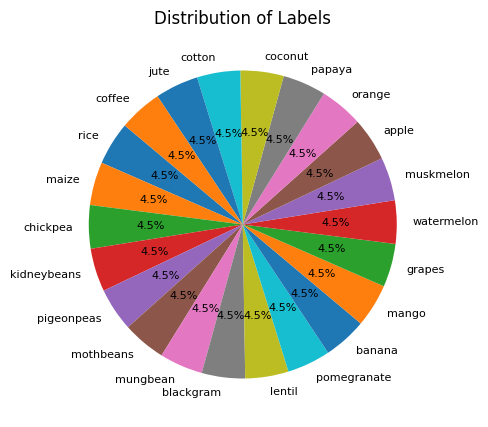

In [60]:
crop_types_count = crops_df['crop'].value_counts()

#  Plot pie chart to show proportions of crop types in the dataset
plt.figure(figsize=(5, 5))
plt.pie(crop_types_count, labels=crop_types_count.index, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 8})
plt.title('Distribution of Labels')
plt.show()

In [61]:
# Compute for correlation to identify highly correlated features, which might indicate redundancy
corr_matrix = crops_df[['N','P','K','ph']].corr()
corr_matrix

,N,P,K,ph
N,1.000000,-0.231460,-0.140512,0.096683
P,-0.231460,1.000000,0.736232,-0.138019
K,-0.140512,0.736232,1.000000,-0.169503
ph,0.096683,-0.138019,-0.169503,1.000000


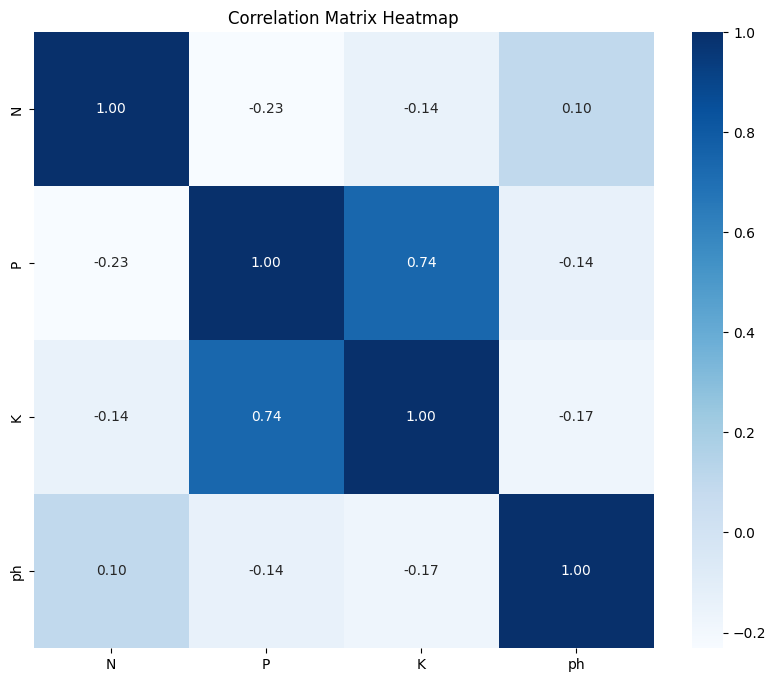

In [62]:
# Plot the heatmap for correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

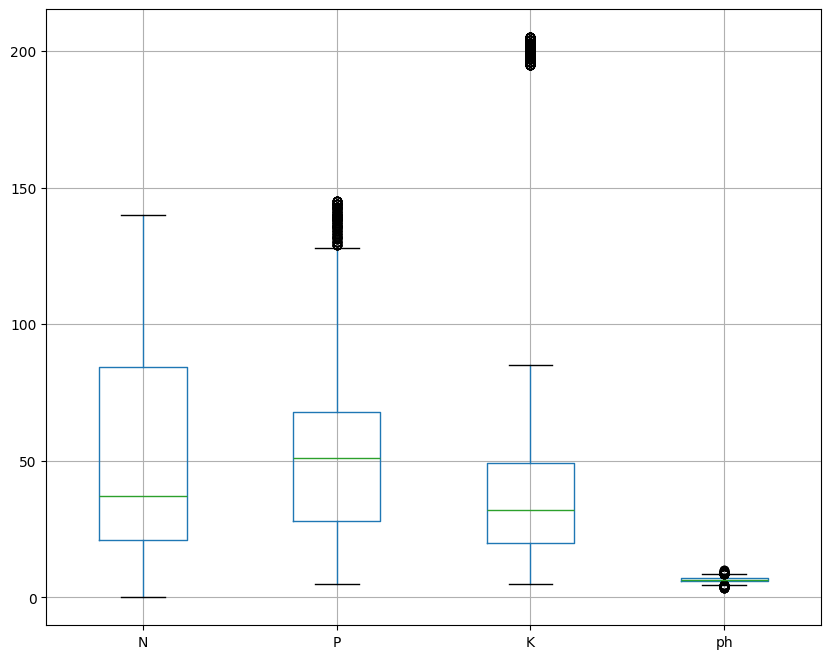

In [63]:
crops_df.boxplot(figsize=(10, 8))
plt.show()

### Data Preprocessing

#### Check for missing values

In [64]:
crops_df.isna().sum()

N       0
P       0
K       0
ph      0
crop    0
dtype: int64

#### Encode `'crop'` column

In [65]:
label_encoder = LabelEncoder()
crops_df['crop'] = label_encoder.fit_transform(crops_df['crop'])

# Code to see which crops correspond to which encoded number
#   crops_df['crop_enc'] = label_encoder.fit_transform(crops_df['crop'])
#   mapping_df = crops_df[['crop', 'crop_enc']].drop_duplicates().sort_values(by='crop_enc')
#   mapping_df

#### Log Transformation (for features that have many outliers)

In [ ]:
# Apply log transformation to 'P' and 'K' and ph columns
log_columns = ['P', 'K', 'ph']
for column in log_columns:
    X[column] = np.log(X[column] + 1)

#### Split the data

In [66]:
X = crops_df.drop('crop', axis=1)
y = crops_df['crop']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#### Feature Scaling

In [68]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Defining the models

In [69]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(solver='lbfgs', max_iter=500),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

#### Training and Testing the models (baseline performance)

In [70]:
model_names = []
accuracies = []
f1_scores = []

# Train, predict and evaluate each model
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    model_names.append(name)
    accuracies.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))  # weighted average for multi-class

# Store the results in df
results_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies,
    'F1 Score': f1_scores
})


#### Plotting baseline performance
**Chosen Metrics:**
- `Accuracy` - measures the proportion of correctly predicted instances out of the total instances. It provides a straightforward measure of overall model performance and is particularly suitable for balanced datasets where each class is equally important.
- `Precision` - measures the proportion of true positive predictions out of the total predicted positives. It is useful for understanding the exactness of the model's predictions, ensuring that a high proportion of predicted positives are actually correct.

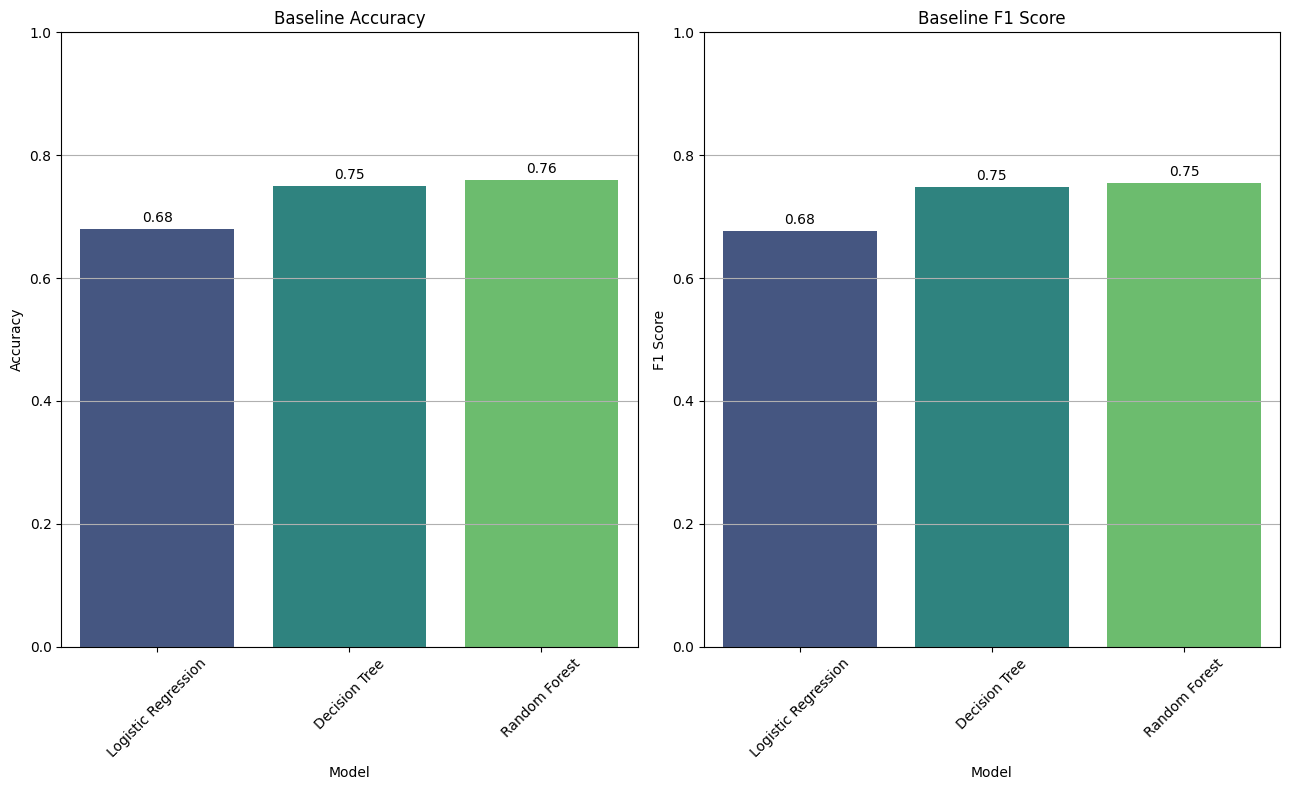

[0.6795454545454546, 0.75, 0.759090909090909]
[np.float64(0.6765235495683837), np.float64(0.7487287379682019), np.float64(0.7545580761951762)]


In [71]:
plt.figure(figsize=(13, 8))

# Plot Accuracy
plt.subplot(1, 2, 1)
ax1 = sns.barplot(x='Model', y='Accuracy', data=results_df, palette='viridis', hue='Model', dodge=False, legend=False)
plt.title('Baseline Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(axis='y')

# Add values on top of bars
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.2f', padding=3)

# Plot F1 Score
plt.subplot(1, 2, 2)
ax2 = sns.barplot(x='Model', y='F1 Score', data=results_df, palette='viridis', hue='Model', dodge=False, legend=False)
plt.title('Baseline F1 Score')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(axis='y')

# Add values on top of bars
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.2f', padding=3)
    
plt.tight_layout()
plt.show()

print(accuracies)
print(f1_scores)

#### Hyperparameter Tuning

In [72]:
# Defining the models and their respective parameters for grid search
models = {
    'Logistic Regression': {
        'model': LogisticRegression(solver='lbfgs', max_iter=200),
        'params': {
            'clf__C': [0.1, 1.0, 10.0],  # Regularization parameter
            'clf__penalty': ['l2']  # Regularization type
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'clf__criterion': ['gini', 'entropy'],  # Split criterion
            'clf__max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
            'clf__min_samples_split': [2, 5, 10]  # Minimum number of samples required to split
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'clf__n_estimators': [50, 100, 200],  # Number of trees
            'clf__max_depth': [None, 10, 20, 30],  # Maximum depth of the trees
            'clf__min_samples_split': [2, 5, 10]  # Minimum number of samples required to split
        }
    }
}

#### Perform GridSearch for Hyperparameter Tuning

In [73]:
best_models = []

# Iterate through each model and perform Grid Search
for model_name, model_params in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', model_params['model'])
    ])
    
    grid_search = GridSearchCV(pipeline, model_params['params'], cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    # Best parameters and score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_model = grid_search.best_estimator_
    
    best_models.append({
        'Model': model_name,
        'Best Parameters': best_params,
        'Best CV Accuracy': best_score
    })


# Print best models summary
print("Best models summary:")
for bm in best_models:
    print(f"Model: {bm['Model']}, Best CV Accuracy: {bm['Best CV Accuracy']:.4f}, Best Parameters: {bm['Best Parameters']}")

Best models summary:
Model: Logistic Regression, Best CV Accuracy: 0.6795, Best Parameters: {'clf__C': 10.0, 'clf__penalty': 'l2'}
Model: Decision Tree, Best CV Accuracy: 0.7943, Best Parameters: {'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__min_samples_split': 2}
Model: Random Forest, Best CV Accuracy: 0.8045, Best Parameters: {'clf__max_depth': 10, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
